# **Import library & inisialisasi dataset**

In [68]:
!git clone https://github.com/Amonstarr/dataset.git

fatal: destination path 'dataset' already exists and is not an empty directory.


In [69]:
!pip install emoji

In [70]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from tabulate import tabulate
import plotly.express as px
import plotly.graph_objects as go

#Pembersihan text twitee
import os
import pickle
import re,string
import emoji
import unicodedata
from html import unescape
import warnings ; warnings,warnings.simplefilter ('ignore')
import nltk
nltk.download('stopwords')
nltk.download('punkt')

#Preprocessing and text handling
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [71]:
#Membaca data set
Label_Twiti = pd.read_csv('dataset_penyisihan_bdc_2024.csv',sep=';')
Label_Twiti

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik
...,...,...
4995,RT @l1DsGGe2xObT3t72dHwqlT58X7jvEYtEnauZIZSYwS...,Politik
4996,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,Politik
4997,imo both are irrational but yg satu jauh lebih...,Ekonomi
4998,@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= ...,Pertahanan dan Keamanan


In [72]:
#Cek nilai null
Label_Twiti.isna().sum()

,0
text,0
label,0


In [73]:
#Melihat info dataset
Label_Twiti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


In [74]:
#Distribusi masing-masing label
Label_Twiti['label'].value_counts()

,count
label,
Politik,2972
Sosial Budaya,587
Ideologi,400
Pertahanan dan Keamanan,400
Ekonomi,367
Sumber Daya Alam,192
Demografi,62
Geografi,20


# **Deep Cleaning**

In [75]:
from typing_extensions import Text
# Menghilangkan Emoji Korup
def emoji_korup(text):
    try:
        kalimat = text.encode('latin1').decode('unicode-escape').encode('latin1').decode('utf8')
    except:
          pass
    return emoji.replace_emoji(text,replace='')

# Menghilangkan semua karakter terkait HTML
import html
def remove_html(text):
  text = html.unescape(text)
  pola_tag = re.compile(r'<.*?>')
  text = pola_tag.sub(r'',text)
  regex_str = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
  pola_url = re.compile(regex_str)
  text = pola_url.sub(r'',text)
  return text

# Membuat Fungsi Untuk Mengganti Karakter yang tidak sesuai dengan standar Non-ASCII menggunakan value equivalent
def kalimat_standar(text):
  text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8','ignore')
  return text

# Menghilangkan link, mentions dan membuat kalimat baru
def pembersihan_linkmentions(text):
    text = text.lower()
    text = text.replace('\r','').replace('\n','')  # hapus karakter baris baru
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # hapus mentions & link
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # hapus karakter non-UTF8
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))  # hapus tanda baca
    text = ' '.join(word for word in text.split() if not word.isnumeric())  # hapus angka
    text = re.sub(r'\b\w\b', "", text)  # hapus kata satu huruf (opsional)
    text = re.sub(r"(username|url|user|rt)\s|\s(user|url|rt)", "", text)  # hapus kata tertentu
    text = ' '.join(word for word in text.split() if 1 < len(word) < 20)  # filter kata: 2-19 huruf
    return text.strip()


# Menghilangkan Spasi
def hapus_spasi(text):
  text = re.sub(r'\s\s+'," ",text)
  return text

# Preprocessing
def preprocess_text(text):
    text = emoji_korup(text)
    text = remove_html(text)
    text = kalimat_standar(text)
    text = pembersihan_linkmentions(text)
    text = hapus_spasi(text)
    return text

In [76]:
# Pembersihan Data
def Pembersihan_Data(text): #fungsi membersihakan text
    text = unescape(text) # mengubah simbol menjadi simbol dalam proses decoding
    text = unescape(text) # encodeing/ mengubah simbol menjadi data menjadi kata

    Ambil_Hastag = re.compile(r"#(\w+)")
    pisahkan_Hastag= re.compile(r'[A-Z][^A-Z]*')
    Tag = re.findall(Ambil_Hastag,text)
    for tag in Tag :
      OutputFilter = ''.join(re.findall(pisahkan_Hastag,tag))
      text = text.replace('#'+tag,OutputFilter) # mengganti hastag menjadi kata dasar
    Lowercase =str(text).lower()
    return text

In [77]:
Kalimat_Baru = Label_Twiti['text'].values
Kalimat_Baru

array(['Kunjungan Prabowo ini untuk meresmikan dan menyerahkan proyek bantuan air bersih di lima titik. #IndonesiaSentris #IndonesiaHijau #02Melanjutkan #AnakMudaIndonesiaEmas Prabowo Subianto',
       'RT Anies dapat tepuk tangan meriah saat jadi Rektor mewajibkan mata kuliah anti-korupsi untuk memutus mata rantai korupsi.. #AminMiskinkanKoruptor https://t.co/hgXsoQGaEa [RE ekowboy2]',
       '@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= emng bener sih, pendukung 01 ada yg goblok, begitu jg dg pendukung 02.. hnya sj menurut pak Ridwan Kamil skemanya terbalik, klo 01 MAYORITAS PENDIDIKAN MENENGAH ATAS (artinya ada jg pendidikan rendah yg milih',
       ...,
       'imo both are irrational but yg satu jauh lebih irrational tbh. but nevertheless dua duanya mesti diluruskan dan baik anies dan ahok KUDU TERLIBAT LANGSUNG untuk validasi trauma mereka. dengan empati lho ya. gitu ae sih.',
       '@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= look at that pak ganjar, anda sdh berkecimpung di

# **Pembersihan Lanjutan**

In [78]:
PembersihanLanjutan = []
for t in Kalimat_Baru:
  PembersihanLanjutan.append(Pembersihan_Data(t))
Kalimat_Baru = PembersihanLanjutan
Kalimat_Baru[:15]

['Kunjungan Prabowo ini untuk meresmikan dan menyerahkan proyek bantuan air bersih di lima titik. IndonesiaSentris IndonesiaHijau Melanjutkan AnakMudaIndonesiaEmas Prabowo Subianto',
 'RT Anies dapat tepuk tangan meriah saat jadi Rektor mewajibkan mata kuliah anti-korupsi untuk memutus mata rantai korupsi.. AminMiskinkanKoruptor https://t.co/hgXsoQGaEa [RE ekowboy2]',
 '@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= emng bener sih, pendukung 01 ada yg goblok, begitu jg dg pendukung 02.. hnya sj menurut pak Ridwan Kamil skemanya terbalik, klo 01 MAYORITAS PENDIDIKAN MENENGAH ATAS (artinya ada jg pendidikan rendah yg milih',
 'RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7Q= Sewaktu anies bersikap kritis ke kinerja pak prabowo dianggap engga sopan karena dianggap kurang menghormati orang tua, giliran skrg gibran yg tengil dan sok kritis malah dianggap kritis dan keras. Apakah ini tidak standar ganda? Ã°ÂŸÂ¤Â\xad [RE coldthem]',
 'Anies Baswedan Harap ASN termasuk TNI dan Polri Pegang Sump

In [79]:
PembersihanLanjutan = []
for t in Kalimat_Baru:
  PembersihanLanjutan.append(emoji_korup(t))
Kalimat_Baru = PembersihanLanjutan
Kalimat_Baru[:15]

['Kunjungan Prabowo ini untuk meresmikan dan menyerahkan proyek bantuan air bersih di lima titik. IndonesiaSentris IndonesiaHijau Melanjutkan AnakMudaIndonesiaEmas Prabowo Subianto',
 'RT Anies dapat tepuk tangan meriah saat jadi Rektor mewajibkan mata kuliah anti-korupsi untuk memutus mata rantai korupsi.. AminMiskinkanKoruptor https://t.co/hgXsoQGaEa [RE ekowboy2]',
 '@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= emng bener sih, pendukung 01 ada yg goblok, begitu jg dg pendukung 02.. hnya sj menurut pak Ridwan Kamil skemanya terbalik, klo 01 MAYORITAS PENDIDIKAN MENENGAH ATAS (artinya ada jg pendidikan rendah yg milih',
 'RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7Q= Sewaktu anies bersikap kritis ke kinerja pak prabowo dianggap engga sopan karena dianggap kurang menghormati orang tua, giliran skrg gibran yg tengil dan sok kritis malah dianggap kritis dan keras. Apakah ini tidak standar ganda? Ã°ÂŸÂ¤Â\xad [RE coldthem]',
 'Anies Baswedan Harap ASN termasuk TNI dan Polri Pegang Sump

In [80]:
PembersihanLanjutan = []
for t in Kalimat_Baru:
  PembersihanLanjutan.append(remove_html(t))
Kalimat_Baru = PembersihanLanjutan
Kalimat_Baru[:15]

['Kunjungan Prabowo ini untuk meresmikan dan menyerahkan proyek bantuan air bersih di lima titik. IndonesiaSentris IndonesiaHijau Melanjutkan AnakMudaIndonesiaEmas Prabowo Subianto',
 'RT Anies dapat tepuk tangan meriah saat jadi Rektor mewajibkan mata kuliah anti-korupsi untuk memutus mata rantai korupsi.. AminMiskinkanKoruptor  [RE ekowboy2]',
 '@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= emng bener sih, pendukung 01 ada yg goblok, begitu jg dg pendukung 02.. hnya sj menurut pak Ridwan Kamil skemanya terbalik, klo 01 MAYORITAS PENDIDIKAN MENENGAH ATAS (artinya ada jg pendidikan rendah yg milih',
 'RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7Q= Sewaktu anies bersikap kritis ke kinerja pak prabowo dianggap engga sopan karena dianggap kurang menghormati orang tua, giliran skrg gibran yg tengil dan sok kritis malah dianggap kritis dan keras. Apakah ini tidak standar ganda? Ã°ÂŸÂ¤Â\xad [RE coldthem]',
 'Anies Baswedan Harap ASN termasuk TNI dan Polri Pegang Sumpahnya dalam Pemilu ',
 

In [81]:
PembersihanLanjutan = []
for t in Kalimat_Baru:
  PembersihanLanjutan.append(kalimat_standar(t))
Kalimat_Baru = PembersihanLanjutan
Kalimat_Baru[:15]

['Kunjungan Prabowo ini untuk meresmikan dan menyerahkan proyek bantuan air bersih di lima titik. IndonesiaSentris IndonesiaHijau Melanjutkan AnakMudaIndonesiaEmas Prabowo Subianto',
 'RT Anies dapat tepuk tangan meriah saat jadi Rektor mewajibkan mata kuliah anti-korupsi untuk memutus mata rantai korupsi.. AminMiskinkanKoruptor  [RE ekowboy2]',
 '@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= emng bener sih, pendukung 01 ada yg goblok, begitu jg dg pendukung 02.. hnya sj menurut pak Ridwan Kamil skemanya terbalik, klo 01 MAYORITAS PENDIDIKAN MENENGAH ATAS (artinya ada jg pendidikan rendah yg milih',
 'RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7Q= Sewaktu anies bersikap kritis ke kinerja pak prabowo dianggap engga sopan karena dianggap kurang menghormati orang tua, giliran skrg gibran yg tengil dan sok kritis malah dianggap kritis dan keras. Apakah ini tidak standar ganda? AAYAA [RE coldthem]',
 'Anies Baswedan Harap ASN termasuk TNI dan Polri Pegang Sumpahnya dalam Pemilu ',
 'RT Du

In [82]:
PembersihanLanjutan = []
for t in Kalimat_Baru:
  PembersihanLanjutan.append(pembersihan_linkmentions(t))
Kalimat_Baru = PembersihanLanjutan
Kalimat_Baru[:15]

['kunjungan prabowo ini untuk meresmikan dan menyerahkan proyek bantuan air bersih di lima titik indonesiasentris indonesiahijau melanjutkan prabowo subianto',
 'anies dapat tepuk tangan meriah saat jadi rektor mewajibkan mata kuliah anti korupsi untuk memutus mata rantai korupsi re ekowboy2',
 'emng bener sih pendukung ada yg goblok begitu jg dg pendukung hnya sj menurut pak ridwan kamil skemanya terbalik klo mayoritas pendidikan menengah atas artinya ada jg pendidikan rendah yg milih',
 'sewaktu anies bersikap kritis ke kinerja pak prabowo dianggap engga sopan karena dianggap kurang menghormati orang tua giliran skrg gibran yg tengil dan sok kritis malah dianggap kritis dan keras apakah ini tidak standar ganda aayaa re coldthem',
 'anies baswedan harap asn termasuk tni dan polri pegang sumpahnya dalam pemilu',
 'duh jangan sampai pak lurah denger nih aayaa di acara hajatan rakyat puluhan ribu warga di kendal serukan aaaganjar presidenaaa kehadiran menjadi magnet bagi puluhan ribu war

In [83]:
PembersihanLanjutan = []
for t in Kalimat_Baru:
  PembersihanLanjutan.append(hapus_spasi(t))
Kalimat_Baru = PembersihanLanjutan
Kalimat_Baru[:15]

['kunjungan prabowo ini untuk meresmikan dan menyerahkan proyek bantuan air bersih di lima titik indonesiasentris indonesiahijau melanjutkan prabowo subianto',
 'anies dapat tepuk tangan meriah saat jadi rektor mewajibkan mata kuliah anti korupsi untuk memutus mata rantai korupsi re ekowboy2',
 'emng bener sih pendukung ada yg goblok begitu jg dg pendukung hnya sj menurut pak ridwan kamil skemanya terbalik klo mayoritas pendidikan menengah atas artinya ada jg pendidikan rendah yg milih',
 'sewaktu anies bersikap kritis ke kinerja pak prabowo dianggap engga sopan karena dianggap kurang menghormati orang tua giliran skrg gibran yg tengil dan sok kritis malah dianggap kritis dan keras apakah ini tidak standar ganda aayaa re coldthem',
 'anies baswedan harap asn termasuk tni dan polri pegang sumpahnya dalam pemilu',
 'duh jangan sampai pak lurah denger nih aayaa di acara hajatan rakyat puluhan ribu warga di kendal serukan aaaganjar presidenaaa kehadiran menjadi magnet bagi puluhan ribu war

# **Check Data**

In [84]:
# Melihat Data untuk lenghth dari row setelah dibersihkan
print('data length: ',len(Kalimat_Baru))

print('\n Data Frame Perbandingan ')
# Import texts baru ke dataframe
Label_Twiti['text_clean'] = Kalimat_Baru
Label_Twiti

data length:  5000

 Data Frame Perbandingan 


,text,label,text_clean
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,kunjungan prabowo ini untuk meresmikan dan men...
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,anies dapat tepuk tangan meriah saat jadi rekt...
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,emng bener sih pendukung ada yg goblok begitu ...
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,sewaktu anies bersikap kritis ke kinerja pak p...
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,anies baswedan harap asn termasuk tni dan polr...
...,...,...,...
4995,RT @l1DsGGe2xObT3t72dHwqlT58X7jvEYtEnauZIZSYwS...,Politik,ngeliat debat kemaren pas prabowo kicep kekira...
4996,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,Politik,masyarakat yakin bahwa prabowo gibran memiliki...
4997,imo both are irrational but yg satu jauh lebih...,Ekonomi,imo both are irrational but yg satu jauh lebih...
4998,@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= ...,Pertahanan dan Keamanan,look at that pak ganjar anda sdh berkecimpung ...


In [85]:
Label_Twiti['text_clean'] = Label_Twiti['text'].apply(preprocess_text)

# **Split Label**

In [86]:
#Splitting Labeled
Label_Twiti_Baru = Label_Twiti[Label_Twiti['label'].notnull()]
Label_Twiti_Baru

,text,label,text_clean
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,kunjungan prabowo ini untuk meresmikan dan men...
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,anies dapat tepuk tangan meriah saat jadi rekt...
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,emng bener sih pendukung ada yg goblok begitu ...
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,sewaktu anies bersikap kritis ke kinerja pak p...
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,anies baswedan harap asn termasuk tni dan polr...
...,...,...,...
4995,RT @l1DsGGe2xObT3t72dHwqlT58X7jvEYtEnauZIZSYwS...,Politik,ngeliat debat kemaren pas prabowo kicep kekira...
4996,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,Politik,masyarakat yakin bahwa prabowo gibran memiliki...
4997,imo both are irrational but yg satu jauh lebih...,Ekonomi,imo both are irrational but yg satu jauh lebih...
4998,@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= ...,Pertahanan dan Keamanan,look at that pak ganjar anda sdh berkecimpung ...


In [87]:
#Splitting Nan
Label_Twiti_Nan = Label_Twiti[Label_Twiti['label'].isnull()]
Label_Twiti_Nan

,text,label,text_clean


In [88]:
#Cek duplikat setelah pembersihan
print('shape:',Label_Twiti_Baru.shape)
print('Duplicated:' ,Label_Twiti_Baru['text_clean'].duplicated().sum())
Label_Twiti_Baru[Label_Twiti_Baru['text_clean'].duplicated()]

shape: (5000, 3)
Duplicated: 706


,text,label,text_clean
57,RT Abah Anies ingin mengangkat martabat petani...,Sosial Budaya,abah anies ingin mengangkat martabat petani ag...
60,RT @0SIRtH1oGVbK2EuKBmDu8IZTnnsgBYm4kuRvLEJJ8l...,Politik,sewaktu anies bersikap kritis ke kinerja pak p...
104,"RT Anak Muda Indonesia, the future of this nat...",Ideologi,anak muda indonesia the future of this nation ...
128,RT Bulan januari ini serangan dari kubu @ZJx5L...,Pertahanan dan Keamanan,bulan januari ini serangan dari kubu dkk akan ...
143,RT Bulan januari ini serangan dari kubu @Lgx1l...,Pertahanan dan Keamanan,bulan januari ini serangan dari kubu dkk akan ...
...,...,...,...
4959,"Bukan cuma tampilan luarnya, tapi kebijakan Ga...",Ideologi,bukan cuma tampilan luarnya tapi kebijakan gan...
4971,"RT menjelang tengah malam ini, aku mau ucapkan...",Ideologi,menjelang tengah malam ini aku mau ucapkan ter...
4983,Investor-friendly! Pasangan Capres Cawapres Ga...,Ekonomi,investor friendly pasangan capres cawapres gan...
4991,RT Bulan januari ini serangan dari kubu @AZr5h...,Pertahanan dan Keamanan,bulan januari ini serangan dari kubu dkk akan ...


In [89]:
#Drop dupliacetd data
Label_Twiti_Baru.drop_duplicates(subset=['text_clean'],inplace=True)
Label_Twiti_Baru
print('New Shape: ',Label_Twiti_Baru.shape)

New Shape:  (4294, 3)


In [90]:
#Cek sell kosong
Label_Twiti_Baru.isna().sum()

,0
text,0
label,0
text_clean,0


In [91]:
#Contain only space row
Label_Twiti_Baru[Label_Twiti_Baru['text_clean'] == '']

,text,label,text_clean
74,@+0HCSSnYXfZ/WiNzDKgSO08o/BKbymxlncndey4/N+E= ...,Sosial Budaya,


In [92]:
#Cek panjang kata setelah cleaning
Label_Twiti_Baru['Length']=Label_Twiti_Baru['text_clean'].str.split().map(lambda x : len(x))
Label_Twiti_Baru

,text,label,text_clean,Length
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,kunjungan prabowo ini untuk meresmikan dan men...,19
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,anies dapat tepuk tangan meriah saat jadi rekt...,20
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,emng bener sih pendukung ada yg goblok begitu ...,31
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,sewaktu anies bersikap kritis ke kinerja pak p...,38
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,anies baswedan harap asn termasuk tni dan polr...,12
...,...,...,...,...
4995,RT @l1DsGGe2xObT3t72dHwqlT58X7jvEYtEnauZIZSYwS...,Politik,ngeliat debat kemaren pas prabowo kicep kekira...,18
4996,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,Politik,masyarakat yakin bahwa prabowo gibran memiliki...,14
4997,imo both are irrational but yg satu jauh lebih...,Ekonomi,imo both are irrational but yg satu jauh lebih...,36
4998,@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= ...,Pertahanan dan Keamanan,look at that pak ganjar anda sdh berkecimpung ...,30


In [93]:
#Hapus data yang berisi satu kata
Label_Twiti_Baru = Label_Twiti_Baru[Label_Twiti_Baru['Length']>1]

#Reset index
Label_Twiti_Baru.reset_index(drop=True,inplace=True)
Label_Twiti_Baru

,text,label,text_clean,Length
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,kunjungan prabowo ini untuk meresmikan dan men...,19
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,anies dapat tepuk tangan meriah saat jadi rekt...,20
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,emng bener sih pendukung ada yg goblok begitu ...,31
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,sewaktu anies bersikap kritis ke kinerja pak p...,38
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,anies baswedan harap asn termasuk tni dan polr...,12
...,...,...,...,...
4287,RT @l1DsGGe2xObT3t72dHwqlT58X7jvEYtEnauZIZSYwS...,Politik,ngeliat debat kemaren pas prabowo kicep kekira...,18
4288,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,Politik,masyarakat yakin bahwa prabowo gibran memiliki...,14
4289,imo both are irrational but yg satu jauh lebih...,Ekonomi,imo both are irrational but yg satu jauh lebih...,36
4290,@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= ...,Pertahanan dan Keamanan,look at that pak ganjar anda sdh berkecimpung ...,30


In [94]:
Label_Twiti_Baru['label'].value_counts()

,count
label,
Politik,2881
Sosial Budaya,397
Ekonomi,270
Pertahanan dan Keamanan,269
Ideologi,259
Sumber Daya Alam,140
Demografi,57
Geografi,19


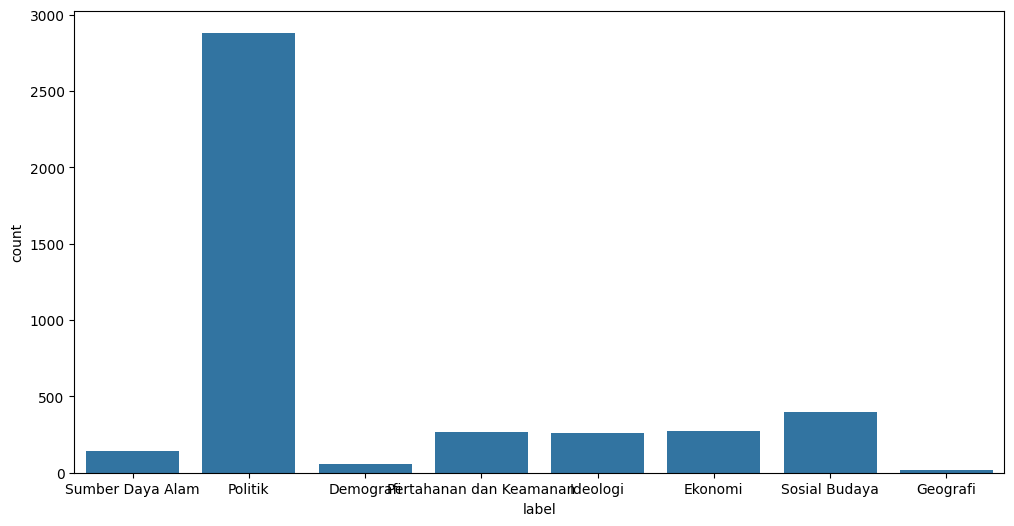

In [95]:
plt.figure (figsize=( 12, 6))
sns.countplot(x='label',data=Label_Twiti_Baru)
plt.show()

In [96]:
# Simpan ke File Untuk Backup
Label_Twiti_Baru.to_csv('Label_Twiti_Baru.csv', encoding = 'utf-8' , index=False)
Label_Twiti_Nan.to_csv('Label_Twiti_Nan.csv',encoding = 'utf-8',index=False)

# **Modelling**

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Gunakan teks hasil preprocessing
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(Label_Twiti_Baru['text_clean'])


In [98]:
# Split the data into training and test sets for the Logistic Regression model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, Label_Twiti_Baru['label'], test_size=0.2, random_state=42)

In [99]:
# Importing & calling Machine learning models

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Support Vector Machine
from sklearn.svm import SVC
svc = SVC(kernel='linear', C=1, probability=True, random_state=42)

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier # Import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Initialize GradientBoostingClassifier

In [100]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, classification_report
)

models = [lr_model, svc, rfc, gb_model] # Use the initialized gb_model
model_names = ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting']
accuracy_scores = []
balanced_scores = []

for model, name in zip(models, model_names):
    print(f'=== {name} ===')

    # Training
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Save scores
    accuracy_scores.append(acc)
    balanced_scores.append(bal_acc)

    # Print scores
    print(f'Accuracy Score         : {acc:.4f}')
    print(f'Balanced Accuracy Score: {bal_acc:.4f}')
    print(f'F1 Score (weighted)    : {f1:.4f}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred, zero_division=0))
    print('='*50)

=== Logistic Regression ===
Accuracy Score         : 0.6752
Balanced Accuracy Score: 0.1789
F1 Score (weighted)    : 0.5696

Classification Report:
                         precision    recall  f1-score   support

              Demografi       0.00      0.00      0.00        16
                Ekonomi       0.81      0.24      0.37        55
               Geografi       0.00      0.00      0.00         3
               Ideologi       1.00      0.16      0.28        56
Pertahanan dan Keamanan       0.25      0.02      0.03        61
                Politik       0.67      0.99      0.80       560
          Sosial Budaya       1.00      0.03      0.05        74
       Sumber Daya Alam       0.00      0.00      0.00        34

               accuracy                           0.68       859
              macro avg       0.47      0.18      0.19       859
           weighted avg       0.66      0.68      0.57       859

=== SVM ===
Accuracy Score         : 0.7229
Balanced Accuracy Score: 

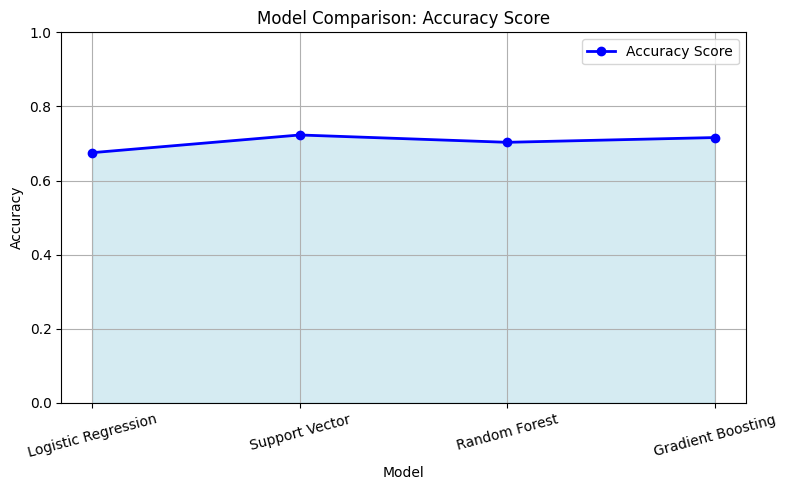

In [101]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Support Vector', 'Random Forest', 'Gradient Boosting']
x = list(range(len(models)))  # index numerik [0,1,2,3]

plt.figure(figsize=(8, 5))
plt.plot(x, accuracy_scores, label='Accuracy Score', marker='o', linestyle='-', color='b', linewidth=2)
plt.fill_between(x, accuracy_scores, color='lightblue', alpha=0.5)

plt.xticks(x, models, rotation=15)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy Score')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

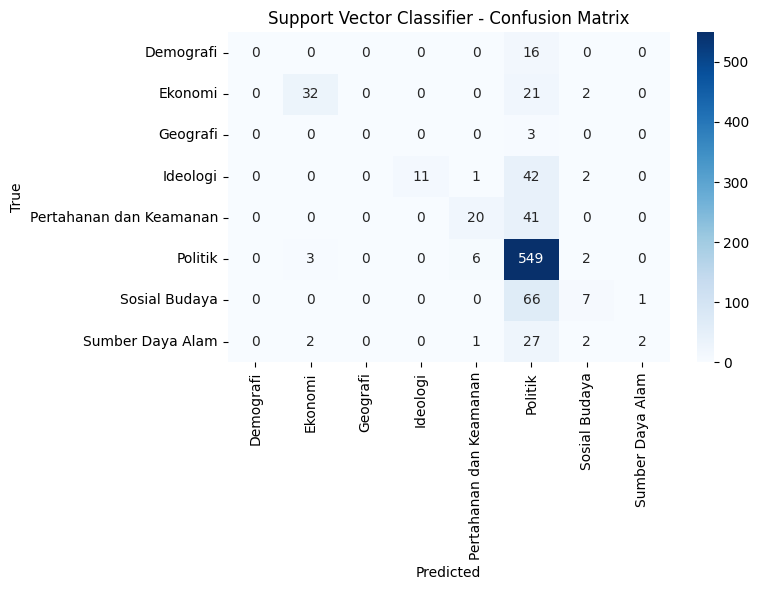

In [102]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Prediksi
y_pred = svc.predict(X_test)

# Ambil label unik dan sort untuk urutan tetap
labels = sorted(list(set(y_test)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Support Vector Classifier - Confusion Matrix')
plt.tight_layout()
plt.show()

In [103]:
print("Classification Report for Support Vector Classifier:\n", classification_report(y_test, y_pred, target_names=Label_Twiti_Baru['label'].unique()))

Classification Report for Support Vector Classifier:
                          precision    recall  f1-score   support

       Sumber Daya Alam       0.00      0.00      0.00        16
                Politik       0.86      0.58      0.70        55
              Demografi       0.00      0.00      0.00         3
Pertahanan dan Keamanan       1.00      0.20      0.33        56
               Ideologi       0.71      0.33      0.45        61
                Ekonomi       0.72      0.98      0.83       560
          Sosial Budaya       0.47      0.09      0.16        74
               Geografi       0.67      0.06      0.11        34

               accuracy                           0.72       859
              macro avg       0.55      0.28      0.32       859
           weighted avg       0.71      0.72      0.66       859



In [104]:
import pandas as pd

# Baca file
df_unlabeled = pd.read_csv('/content/dataset/dataset_unlabeled_penyisihan_bdc_2024.csv', delimiter=';')

# Preprocessing (gunakan fungsi yang sebelumnya kamu buat)
df_unlabeled['cleaned_text'] = df_unlabeled['Text'].astype(str).apply(preprocess_text)

In [105]:
display(df_unlabeled)

,IDText,Text,cleaned_text
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,lu mau org2 pro demokrasi di negara ini bisa p...
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya soal hutang luar negeri dia me...
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki daliyo ganjar pranowo itulah beliau sosok...
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran yang bisa melakukan itu semua d...
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,lah justru yg gak nyambung junjungan elu aomkm...
...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...",bikin bangga deh ganjar mahfud mau alokasikan ...
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,pak jokowi sebelum pilpres berbesar hati meran...
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,sbaiknya si gemot nga usah ikutan debat deh ng...
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk atau bermusyawarah jadi gay...


In [106]:
# Transform cleaned text to TF-IDF
X_unlabeled = tfidf_vectorizer.transform(df_unlabeled['cleaned_text'])

In [211]:
# Prediksi label
df_unlabeled['kelas'] = gb_model.predict(X_unlabeled)

In [212]:
# Tampilkan hasil prediksi pertama
df_unlabeled[['IDText', 'kelas']].head(10)

,IDText,kelas
0,TXT0001,Politik
1,TXT0002,Politik
2,TXT0003,Ideologi
3,TXT0004,Politik
4,TXT0005,Politik
5,TXT0006,Politik
6,TXT0007,Politik
7,TXT0008,Politik
8,TXT0009,Politik
9,TXT0010,Ekonomi


In [213]:
# Tampilkan hasil prediksi
df_unlabeled[['IDText', 'kelas', 'cleaned_text', 'Text']].head(10)

,IDText,kelas,cleaned_text,Text
0,TXT0001,Politik,lu mau org2 pro demokrasi di negara ini bisa p...,Lu mau org2 pro-demokrasi di negara ini bisa p...
1,TXT0002,Politik,prabowo ditanya soal hutang luar negeri dia me...,Prabowo ditanya soal hutang luar negeri dia me...
2,TXT0003,Ideologi,kiki daliyo ganjar pranowo itulah beliau sosok...,kiki_daliyo Ganjar Pranowo itulah beliau soso...
3,TXT0004,Politik,prabowo gibran yang bisa melakukan itu semua d...,@kumparan Prabowo Gibran yang bisa melakukan i...
4,TXT0005,Politik,lah justru yg gak nyambung junjungan elu aomkm...,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...
5,TXT0006,Politik,nelayan tak bisa terus terjebak dalam kredit m...,Nelayan tak bisa terus terjebak dalam kredit m...
6,TXT0007,Politik,prabowo anti kebebasan pers,Prabowo anti kebebasan pers\n\nhttps://t.co/7S...
7,TXT0008,Politik,kontrak terbuka ganjar pranowo adalah cermin d...,Kontrak terbuka Ganjar Pranowo adalah cermin d...
8,TXT0009,Politik,aayaa12 ganjar mahfud hebat coblos3 3gm ganjar...,Ã°ÂŸÂÂ½ Ganjar Mahfud Hebat #Coblos3 #3GM #G...
9,TXT0010,Ekonomi,ganjar mahfud adalah harapan baru untuk pertum...,Ganjar-Mahfud adalah harapan baru untuk pertum...


In [214]:
# Simpan ke file baru
df_unlabeled[['IDText', 'kelas']].to_csv('hasil_prediksi_svc.csv', index=False)

In [215]:
# Gunakan teks hasil preprocessing
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df_unlabeled['cleaned_text'])

In [216]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier # Import GradientBoostingClassifier
gb_model_unlabel = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Initialize GradientBoostingClassifier

In [217]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, classification_report)

models = [gb_model_unlabel] # Use the initialized gb_model
model_names = ['Gradient Boosting']
accuracy_scores = []
balanced_scores = []

for model, name in zip(models, model_names):
    print(f'=== {name} ===')

    # Training
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Save scores
    accuracy_scores.append(acc)
    balanced_scores.append(bal_acc)

    # Print scores
    print(f'Accuracy Score         : {acc:.4f}')
    print(f'Balanced Accuracy Score: {bal_acc:.4f}')
    print(f'F1 Score (weighted)    : {f1:.4f}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred, zero_division=0))
    print('='*50)

=== Gradient Boosting ===
Accuracy Score         : 0.9576
Balanced Accuracy Score: 0.8849
F1 Score (weighted)    : 0.9556

Classification Report:
                         precision    recall  f1-score   support

              Demografi       1.00      1.00      1.00         2
                Ekonomi       0.93      1.00      0.97        14
               Ideologi       1.00      0.67      0.80         3
Pertahanan dan Keamanan       1.00      0.77      0.87        13
                Politik       0.96      0.99      0.97        86

               accuracy                           0.96       118
              macro avg       0.98      0.88      0.92       118
           weighted avg       0.96      0.96      0.96       118



# **Undersampling Kelas Mayoritas**

Untuk mengatasi ketidakseimbangan kelas dalam data, digunakan strategi selektif berupa undersampling terhadap kelas mayoritas, sementara seluruh data dari kelas minoritas tetap dipertahankan agar tidak kehilangan informasi penting. Pendekatan ini bertujuan untuk menghasilkan model yang lebih seimbang dan tidak bias terhadap kelas yang dominan

In [219]:
# Cek distribusi label
label_counts = df_unlabeled['kelas'].value_counts()
print(label_counts)

kelas
Politik                    828
Ekonomi                     84
Pertahanan dan Keamanan     49
Ideologi                    11
Sosial Budaya                9
Sumber Daya Alam             8
Demografi                    7
Geografi                     4
Name: count, dtype: int64


In [220]:
# Threshold mayoritas
threshold = 100
majority_labels = label_counts[label_counts > threshold].index
minority_labels = label_counts[label_counts <= threshold].index

In [221]:
# Data mayoritas dan minoritas
majority_data = df_unlabeled[df_unlabeled['kelas'].isin(majority_labels)]
minority_data = df_unlabeled[df_unlabeled['kelas'].isin(minority_labels)]

In [222]:
# Undersample mayoritas
undersampled_majority = majority_data.groupby('kelas').sample(frac=0.5, random_state=42)

In [223]:
balanced_df = pd.concat([undersampled_majority, minority_data])

In [224]:
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [225]:
# TF-IDF dan training split
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(balanced_df['cleaned_text'])

X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, balanced_df['kelas'], test_size=0.2, random_state=42)

In [226]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight

In [227]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [228]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.9576271186440678
Balanced Accuracy: 0.8848539057841383
F1 Score: 0.9556309012563937
                         precision    recall  f1-score   support

              Demografi       1.00      1.00      1.00         2
                Ekonomi       0.93      1.00      0.97        14
               Ideologi       1.00      0.67      0.80         3
Pertahanan dan Keamanan       1.00      0.77      0.87        13
                Politik       0.96      0.99      0.97        86

               accuracy                           0.96       118
              macro avg       0.98      0.88      0.92       118
           weighted avg       0.96      0.96      0.96       118



In [230]:
# Hasil prediksi
df_unlabeled[['IDText', 'kelas', 'cleaned_text', 'Text']].head(10)

,IDText,kelas,cleaned_text,Text
0,TXT0001,Politik,lu mau org2 pro demokrasi di negara ini bisa p...,Lu mau org2 pro-demokrasi di negara ini bisa p...
1,TXT0002,Politik,prabowo ditanya soal hutang luar negeri dia me...,Prabowo ditanya soal hutang luar negeri dia me...
2,TXT0003,Ideologi,kiki daliyo ganjar pranowo itulah beliau sosok...,kiki_daliyo Ganjar Pranowo itulah beliau soso...
3,TXT0004,Politik,prabowo gibran yang bisa melakukan itu semua d...,@kumparan Prabowo Gibran yang bisa melakukan i...
4,TXT0005,Politik,lah justru yg gak nyambung junjungan elu aomkm...,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...
5,TXT0006,Politik,nelayan tak bisa terus terjebak dalam kredit m...,Nelayan tak bisa terus terjebak dalam kredit m...
6,TXT0007,Politik,prabowo anti kebebasan pers,Prabowo anti kebebasan pers\n\nhttps://t.co/7S...
7,TXT0008,Politik,kontrak terbuka ganjar pranowo adalah cermin d...,Kontrak terbuka Ganjar Pranowo adalah cermin d...
8,TXT0009,Politik,aayaa12 ganjar mahfud hebat coblos3 3gm ganjar...,Ã°ÂŸÂÂ½ Ganjar Mahfud Hebat #Coblos3 #3GM #G...
9,TXT0010,Ekonomi,ganjar mahfud adalah harapan baru untuk pertum...,Ganjar-Mahfud adalah harapan baru untuk pertum...


In [234]:
# Simpan ke file baru
df_unlabeled[['IDText', 'kelas']].to_csv('hasil_prediksi_model.csv',index=False)